In [1]:
# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Advanced ML libraries
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load the Excel file
file_path = 'Rotten_Tomatoes_Movies3.xls'  # Update the path as needed
df = pd.read_excel(file_path)

# Step 1: Drop rows with missing target
df_clean = df.dropna(subset=['audience_rating'])

# Step 2: Drop unnecessary columns
columns_to_drop = ['movie_title', 'on_streaming_date', 'in_theaters_date']
df_clean = df_clean.drop(columns=columns_to_drop)

# Step 3: Identify categorical and numerical columns
categorical_features = df_clean.select_dtypes(include=['object', 'category']).columns
numerical_features = df_clean.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features.drop('audience_rating')  # Remove target from numerical features

# Step 4: Handle missing values
df_clean[categorical_features] = df_clean[categorical_features].fillna('unknown')
df_clean[numerical_features] = df_clean[numerical_features].fillna(df_clean[numerical_features].mean())


In [5]:
# Separate features (X) and target (y)
X = df_clean.drop(columns=['audience_rating'])
y = df_clean['audience_rating']

# Split the data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Handle missing values and scaling for numerical data
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Handle missing values and encoding for categorical data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features)
    ]
)


In [19]:
# Define models to try
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'SVR': SVR()
}

# Store model results in a list instead of appending to DataFrame
results_list = []

# Train and evaluate each model
for name, model in models.items():
    try:
        print(f"🚀 Training {name}...")
        
        # Create the pipeline with preprocessing and the current model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Fit the model
        pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Print the model's metrics
        print(f"📈 {name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
        
        # Store the model results
        results_list.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
        
    except Exception as e:
        print(f"⚠️ Error training {name}: {e}")

# Convert the list of results into a DataFrame
results = pd.DataFrame(results_list)

# Sort by R2 score (highest to lowest)
results_sorted = results.sort_values(by='R2', ascending=False)

# Display the results
print("\n📊 Final Model Comparison Results")
print(results_sorted)


🚀 Training Linear Regression...
📈 Linear Regression - MAE: 10.9602, RMSE: 13.9209, R2: 0.5304
🚀 Training Decision Tree...
📈 Decision Tree - MAE: 13.8786, RMSE: 17.9536, R2: 0.2190
🚀 Training Random Forest...
📈 Random Forest - MAE: 11.4294, RMSE: 14.7035, R2: 0.4762
🚀 Training Gradient Boosting...
📈 Gradient Boosting - MAE: 11.3894, RMSE: 14.2302, R2: 0.5094
🚀 Training XGBoost...
📈 XGBoost - MAE: 11.0176, RMSE: 13.9696, R2: 0.5272
🚀 Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 966
[LightGBM] [Info] Number of data points in the train set: 13108, number of used features: 228
[LightGBM] [Info] Start training from score 60.430424
📈 LightGBM - MAE: 11.0017, RMSE: 13.9293, R2: 0.5299
🚀 Training SVR...
📈 SVR - MAE: 12.3621, RMSE: 16.3569, R2: 0.3517

📊 Final Model Co

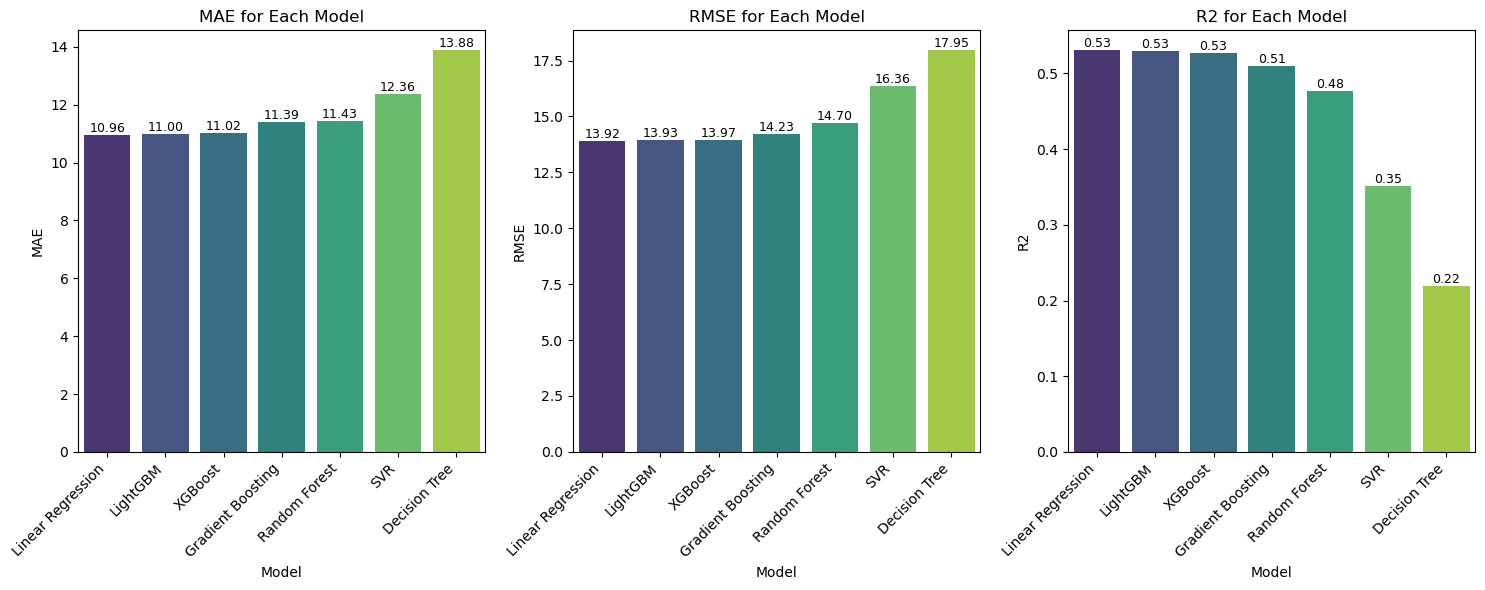

In [21]:
# Plotting the bar charts for MAE, RMSE, and R2
metrics = ['MAE', 'RMSE', 'R2']

# Set the plot size
plt.figure(figsize=(15, 6))

# Loop through each metric to create a barplot
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)  # Create subplots (1 row, 3 columns)
    sns.barplot(x='Model', y=metric, data=results_sorted, palette='viridis')
    plt.title(f'{metric} for Each Model')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
    plt.xlabel('Model')
    plt.ylabel(metric)
    for index, value in enumerate(results_sorted[metric]):
        plt.text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=9)  # Add text annotations

plt.tight_layout()
plt.show()

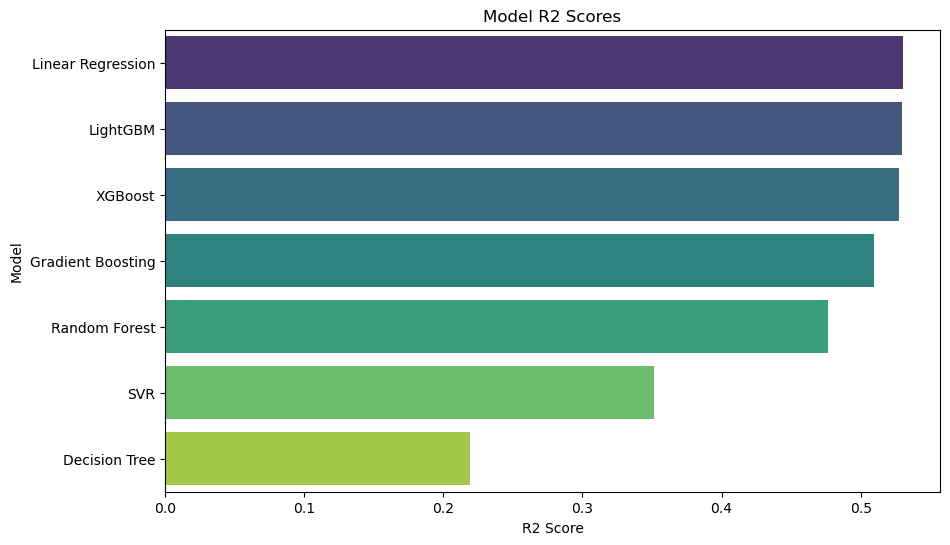

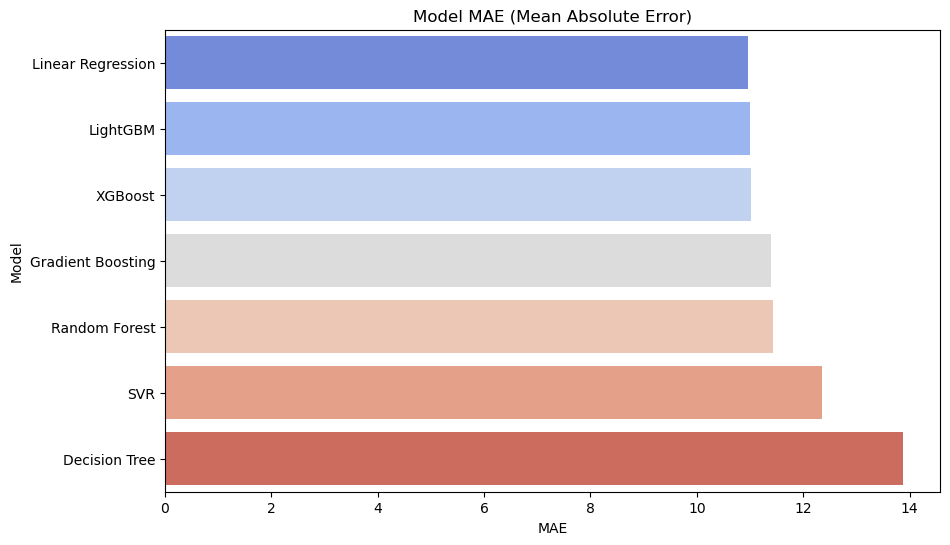

In [25]:
# Sort the models by R2 score
results_sorted = results.sort_values(by='R2', ascending=False)

# Plot the performance
plt.figure(figsize=(10, 6))
sns.barplot(x='R2', y='Model', data=results_sorted, palette='viridis')
plt.title('Model R2 Scores')
plt.xlabel('R2 Score')
plt.ylabel('Model')
plt.show()

# Plot the MAE (Mean Absolute Error)
plt.figure(figsize=(10, 6))
sns.barplot(x='MAE', y='Model', data=results_sorted, palette='coolwarm')
plt.title('Model MAE (Mean Absolute Error)')
plt.xlabel('MAE')
plt.ylabel('Model')
plt.show()


In [27]:
# Identify the best model
best_model_name = results_sorted.iloc[0]['Model']
print(f"🎉 Best Model: {best_model_name}")

# Train the best model on the entire dataset
best_model = models[best_model_name]
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])
final_pipeline.fit(X, y)

# Save the model
import joblib
joblib.dump(final_pipeline, 'best_audience_rating_model.pkl')
print(f"Best model ({best_model_name}) saved as 'best_audience_rating_model.pkl'")


🎉 Best Model: Linear Regression


TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['int', 'str']

In [13]:
import time
import warnings
from sklearn.model_selection import cross_val_score

# Define models to try
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'SVR': SVR()
}

# Store model results in a list instead of appending to DataFrame
results_list = []

# Train and evaluate each model
for name, model in models.items():
    try:
        print(f"🚀 Training {name}...")
        
        # Create the pipeline with preprocessing and the current model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Measure start time
        start_time = time.time()
        
        # Fit the model
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            pipeline.fit(X_train, y_train)
        
        # Measure end time
        end_time = time.time()
        training_time = end_time - start_time
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Print the model's metrics
        print(f"📈 {name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, Time: {training_time:.2f}s")
        
        # Store the model results
        results_list.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Time (s)': training_time})
        
        # Feature Importance for tree-based models
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            features = X_train.columns
            importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
            importance_df.sort_values(by='Importance', ascending=False, inplace=True)
            
            # Optional: plot the feature importances
            plt.figure(figsize=(10, 6))
            plt.barh(importance_df['Feature'], importance_df['Importance'])
            plt.title(f'Feature Importance for {name}')
            plt.show()
        
    except Exception as e:
        print(f"⚠️ Error training {name}: {e}")

# Convert the list of results into a DataFrame
results = pd.DataFrame(results_list)

# Sort by R2 score (highest to lowest)
results_sorted = results.sort_values(by='R2', ascending=False)

# Display the results
print("\n📊 Final Model Comparison Results")
print(results_sorted)


🚀 Training Linear Regression...
📈 Linear Regression - MAE: 10.9602, RMSE: 13.9209, R2: 0.5304, Time: 1.57s
🚀 Training Decision Tree...
📈 Decision Tree - MAE: 13.8786, RMSE: 17.9536, R2: 0.2190, Time: 20.70s
⚠️ Error training Decision Tree: All arrays must be of the same length
🚀 Training Random Forest...


KeyboardInterrupt: 

ValueError: num must be an integer with 1 <= num <= 3, not 4

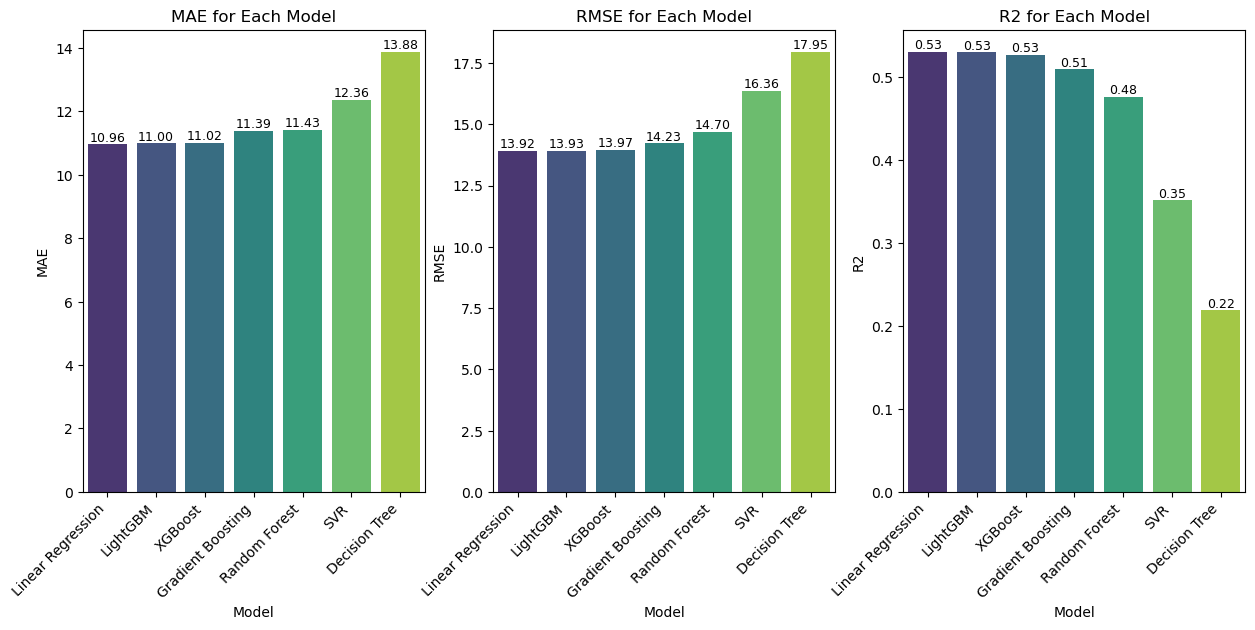

In [11]:
# Plotting the bar charts for MAE, RMSE, and R2
metrics = ['MAE', 'RMSE', 'R2','Time']

# Set the plot size
plt.figure(figsize=(15, 6))

# Loop through each metric to create a barplot
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)  # Create subplots (1 row, 3 columns)
    sns.barplot(x='Model', y=metric, data=results_sorted, palette='viridis')
    plt.title(f'{metric} for Each Model')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
    plt.xlabel('Model')
    plt.ylabel(metric)
    for index, value in enumerate(results_sorted[metric]):
        plt.text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=9)  # Add text annotations

plt.tight_layout()
plt.show()